<a href="https://colab.research.google.com/github/PhungTrinhUET/Citrus-leaf-diseases/blob/main/MobileNetV3-Small-Dense64_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About

- [Dataset](https://drive.google.com/file/d/12nU-nTEek27n7Sq7ZT9_efcc7T-DEjL-/view?usp=drive_link)

# Implementation


## Install requirements & download datasets


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "./gdrive/MyDrive/citrus3.zip" -d '/usr/local'

Streaming output truncated to the last 5000 lines.
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (705).jpg  
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (706).jpg  
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (707).jpg  
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (708).jpg  
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (709).jpg  
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (710).jpg  
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (711).jpg  
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (712).jpg  
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (713).jpg  
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (714).jpg  
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (715).jpg  
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (716).jpg  
  inflating: /usr/local/data_citrus/black_spot/c_black_spot (717).jpg  
  inflating: 

## Import Libraries


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import glob
import warnings
warnings.filterwarnings('ignore')

## Read Dataset

In [ ]:
train_data_dir = "/usr/local/data_citrus/"
pd.DataFrame(os.listdir(train_data_dir), columns = ['Files_name'])

,Files_name
0,canker
1,melanose
2,black_spot
3,greening
4,healthy


In [ ]:
files = [i for i in glob.glob(train_data_dir + "//*//*")]
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]
data = zip(files, labels)
dataframe = pd.DataFrame(data, columns = ["Images", "Label"])
dataframe

,Images,Label
0,/usr/local/data_citrus/healthy/c_healthy (5256...,healthy
1,/usr/local/data_citrus/greening/c_greening (31...,greening
2,/usr/local/data_citrus/canker/c_canker (4244).jpg,canker
3,/usr/local/data_citrus/greening/c_greening (33...,greening
4,/usr/local/data_citrus/melanose/c_melanose (10...,melanose
...,...,...
5974,/usr/local/data_citrus/black_spot/c_black_spot...,black_spot
5975,/usr/local/data_citrus/melanose/c_melanose (53...,melanose
5976,/usr/local/data_citrus/healthy/c_healthy (5229...,healthy
5977,/usr/local/data_citrus/greening/c_greening (29...,greening


## Data Visualization

([0, 1, 2, 3, 4],
 [Text(0, 0, 'healthy'),
  Text(1, 0, 'greening'),
  Text(2, 0, 'canker'),
  Text(3, 0, 'melanose'),
  Text(4, 0, 'black_spot')])

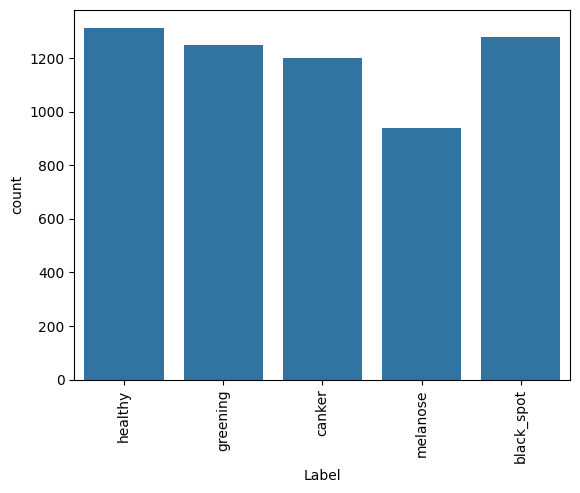

In [ ]:
sns.countplot(x = dataframe["Label"])
plt.xticks(rotation = 90)

## Split Dataset

In [ ]:
batch_size = 64
target_size = (224,224)
validation_split = 0.2
train_gen = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split = validation_split,
    subset="training",
    seed = 200,
    image_size = target_size,
    batch_size = batch_size
)
valid_gen = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split = validation_split,
    subset="validation",
    seed = 100,
    image_size = target_size,
    batch_size = batch_size
)

Found 5979 files belonging to 5 classes.
Using 4784 files for training.
Found 5979 files belonging to 5 classes.
Using 1195 files for validation.


In [ ]:
class_names = train_gen.class_names
class_names

['black_spot', 'canker', 'greening', 'healthy', 'melanose']

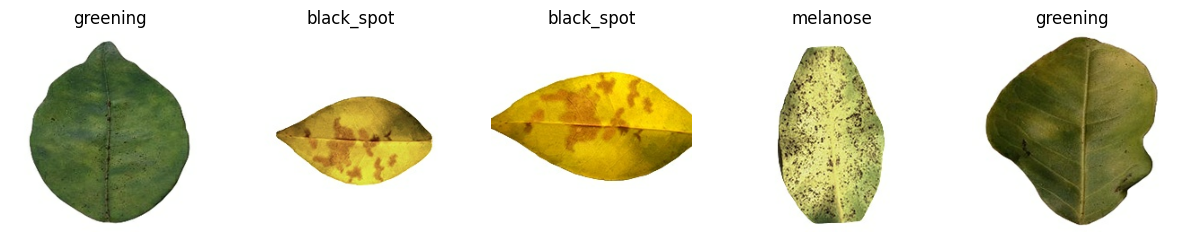

In [ ]:
plt.figure(figsize=(15,20))
for images, labels in train_gen.take(1):
  for i in range(5):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Modelling Network

In [ ]:
base_model = tf.keras.applications.MobileNetV3Small(input_shape=(224,224,3),
                                                    include_top=False, weights='imagenet')
base_model.trainable = False
citrus = keras.models.Sequential()
citrus.add(base_model)
citrus.add(keras.layers.Flatten())
citrus.add(keras.layers.Dropout(0.8))
citrus.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))  # Added dens e layer with L2 regularization
citrus.add(keras.layers.Dense(5, activation = tf.nn.softmax))
citrus.summary()

4334752/4334752 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 28224)             0         
                                                                 
 dropout (Dropout)           (None, 28224)             0         
                                                                 
 dense (Dense)               (None, 64)                1806400   
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 2745845 (10.47 MB)
Trainable params: 1806725 

In [ ]:
!pip install pydot

In [ ]:
tf.keras.utils.plot_model(citrus, to_file = 'model.png', show_shapes=True,
                          show_layer_names=True, show_dtype=True, dpi=600)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
checkpoint = ModelCheckpoint("citrus_mbv3.h5", save_best_onnly="True")

In [ ]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

## Training Phase

In [ ]:
citrus.compile(optimizer ='SGD',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hist=citrus.fit_generator(train_gen, epochs=50, validation_data=valid_gen, callbacks=[checkpoint,early_stopping])

Epoch 1/50
75/75 [==============================] - 18s 196ms/step - loss: 2.1986 - accuracy: 0.8232 - val_loss: 1.4182 - val_accuracy: 0.9456
Epoch 2/50
75/75 [==============================] - 14s 181ms/step - loss: 1.4936 - accuracy: 0.9168 - val_loss: 1.3579 - val_accuracy: 0.9498
Epoch 3/50
75/75 [==============================] - 14s 180ms/step - loss: 1.4072 - accuracy: 0.9331 - val_loss: 1.3186 - val_accuracy: 0.9523
Epoch 4/50
75/75 [==============================] - 13s 175ms/step - loss: 1.3565 - accuracy: 0.9406 - val_loss: 1.2592 - val_accuracy: 0.9724
Epoch 5/50
75/75 [==============================] - 13s 169ms/step - loss: 1.3077 - accuracy: 0.9505 - val_loss: 1.2244 - val_accuracy: 0.9699
Epoch 6/50
75/75 [==============================] - 13s 177ms/step - loss: 1.2646 - accuracy: 0.9536 - val_loss: 1.1975 - val_accuracy: 0.9690
Epoch 7/50
75/75 [==============================] - 13s 179ms/step - loss: 1.2168 - accuracy: 0.9544 - val_loss: 1.1502 - val_accuracy: 0.9741

In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,2.198552,0.823161,1.418165,0.945607
1,1.493623,0.916806,1.357934,0.949791
2,1.407214,0.933110,1.318593,0.952301
3,1.356517,0.940635,1.259174,0.972385
4,1.307706,0.950460,1.224415,0.969875
5,1.264613,0.953595,1.197547,0.969038
6,1.216846,0.954431,1.150198,0.974059
7,1.184449,0.958403,1.116440,0.979079
8,1.152437,0.959239,1.085397,0.973222
9,1.119647,0.961747,1.054584,0.978243


In [ ]:
import os
import shutil

def get_model_size(model):
    model.save('temp_model')
    size = sum(os.path.getsize(os.path.join('temp_model', f)) for f in os.listdir('temp_model') if os.path.isfile(os.path.join('temp_model', f)))
    size_mb = size / (1024 * 1024)  # Đổi từ byte sang MB
    shutil.rmtree('temp_model')  # Xóa thư mục tạm thời sau khi tính toán
    return size_mb

model_size_mb = get_model_size(citrus)
print(f'Model size: {model_size_mb:.2f} MB')


Model size: 3.06 MB


In [ ]:
import time
import numpy as np

def get_inference_time(model, input_shape=(224, 224, 3)):
    input_data = np.random.random([1] + list(input_shape)).astype(np.float32)
    start_time = time.time()
    _ = model.predict(input_data)
    end_time = time.time()
    inference_time_ms = (end_time - start_time) * 1000  # Đổi từ giây sang mili giây
    return inference_time_ms

inference_time_ms = get_inference_time(citrus)
print(f'Speed of single image recognition: {inference_time_ms:.2f} ms')


1/1 [==============================] - 1s 975ms/step
Speed of single image recognition: 1037.41 ms


## Accuracy

In [ ]:
score, acc = citrus.evaluate(train_gen)
print("Train Loss =", score)
print("Train Accuracy =", acc)

75/75 [==============================] - 10s 130ms/step - loss: 0.3518 - accuracy: 0.9937
Train Loss = 0.35178694128990173
Train Accuracy = 0.9937291145324707


In [ ]:
score_v, acc_v = citrus.evaluate(valid_gen)
print("Test Loss =", score_v)
print("Test Accuracy =", acc_v)

19/19 [==============================] - 3s 130ms/step - loss: 0.3594 - accuracy: 0.9916
Test Loss = 0.35941532254219055
Test Accuracy = 0.991631805896759


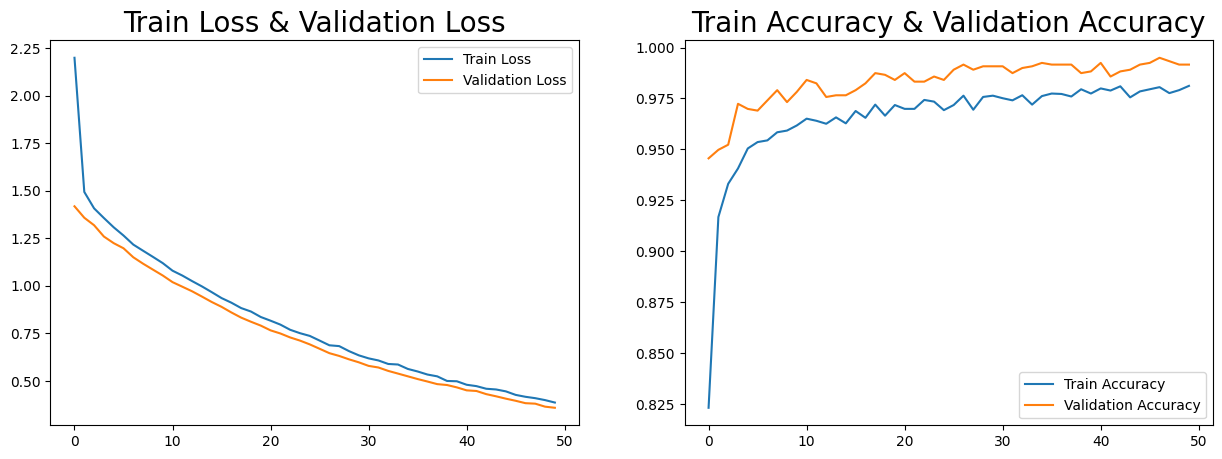

In [ ]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'], label="Train Loss")
plt.plot(hist_['val_loss'], label="Validation Loss")
plt.title("Train Loss & Validation Loss", fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'], label="Train Accuracy")
plt.plot(hist_['val_accuracy'], label="Validation Accuracy")
plt.title("Train Accuracy & Validation Accuracy", fontsize=20)
plt.legend()

2/2 [==============================] - 0s 36ms/step
Precision: 0.9958071112632751
Recall: 0.9989484548568726


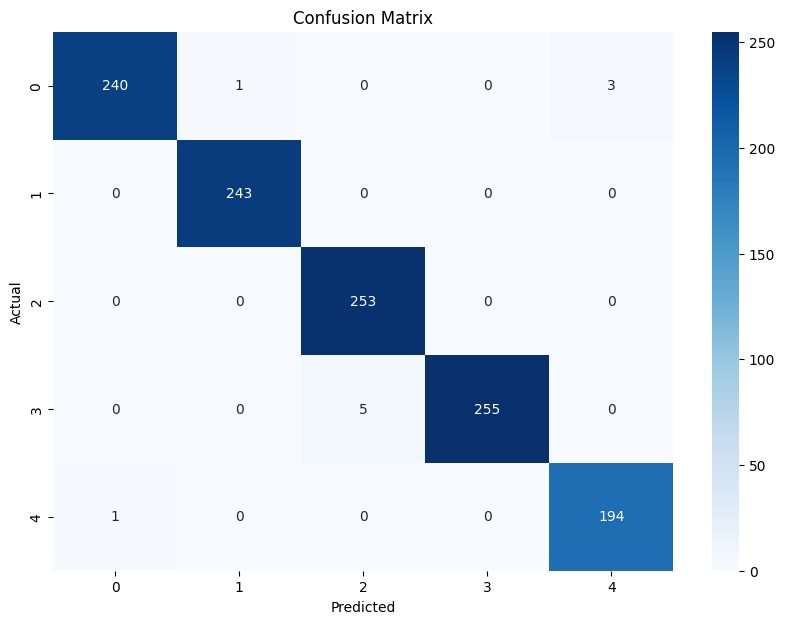

In [ ]:
## Precision, Recall, and Confusion Matrix
# Evaluate the model and get predictions
y_true = []
y_pred = []

for images, labels in valid_gen:
    predictions = citrus.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)

# Convert lists to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate Precision and Recall
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

precision.update_state(y_true, y_pred)
recall.update_state(y_true, y_pred)

precision_score = precision.result().numpy()
recall_score = recall.result().numpy()

print(f"Precision: {precision_score}")
print(f"Recall: {recall_score}")

# Plotting the confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=[i for i in range(len(cm))], columns=[i for i in range(len(cm))])

plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

F1 Score: 0.9916284157765876


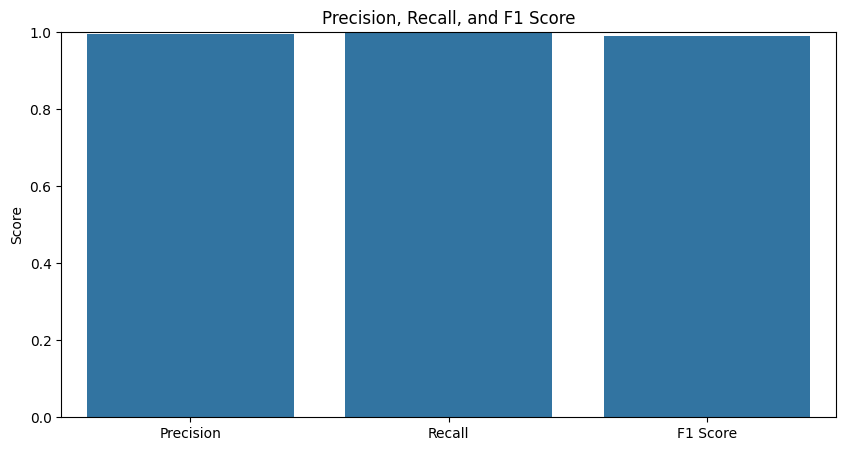

In [ ]:
## F1 Score
from sklearn.metrics import f1_score

# Calculate F1 Score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1}")

# Plotting Precision, Recall, and F1 Score
precision_score = precision.result().numpy()
recall_score = recall.result().numpy()

metrics = ['Precision', 'Recall', 'F1 Score']
scores = [precision_score, recall_score, f1]

plt.figure(figsize=(10, 5))
sns.barplot(x=metrics, y=scores)
plt.ylim(0, 1)
plt.title('Precision, Recall, and F1 Score')
plt.ylabel('Score')
plt.show()


In [ ]:
print(f"Precision: {precision_score}")
print(f"Recall: {recall_score}")

Precision: 0.9958071112632751
Recall: 0.9989484548568726


In [ ]:
print(f"F1 Score: {f1}")

F1 Score: 0.9916284157765876


In [ ]:
print("Train Loss =", score)
print("Train Accuracy =", acc)
print("Test Loss =", score_v)
print("Test Accuracy =", acc_v)

Train Loss = 0.35178694128990173
Train Accuracy = 0.9937291145324707
Test Loss = 0.35941532254219055
Test Accuracy = 0.991631805896759


Precision per class:
Black spot: 0.995850622406639
Canker: 0.9959016393442623
Greening: 0.9806201550387597
Healthy: 1.0
Melanose: 0.9847715736040609

Recall per class:
Black spot: 0.9836065573770492
Canker: 1.0
Greening: 1.0
Healthy: 0.9807692307692307
Melanose: 0.9948717948717949

F1 Score per class:
Black spot: 0.9896907216494845
Canker: 0.997946611909651
Greening: 0.9902152641878669
Healthy: 0.9902912621359222
Melanose: 0.9897959183673469


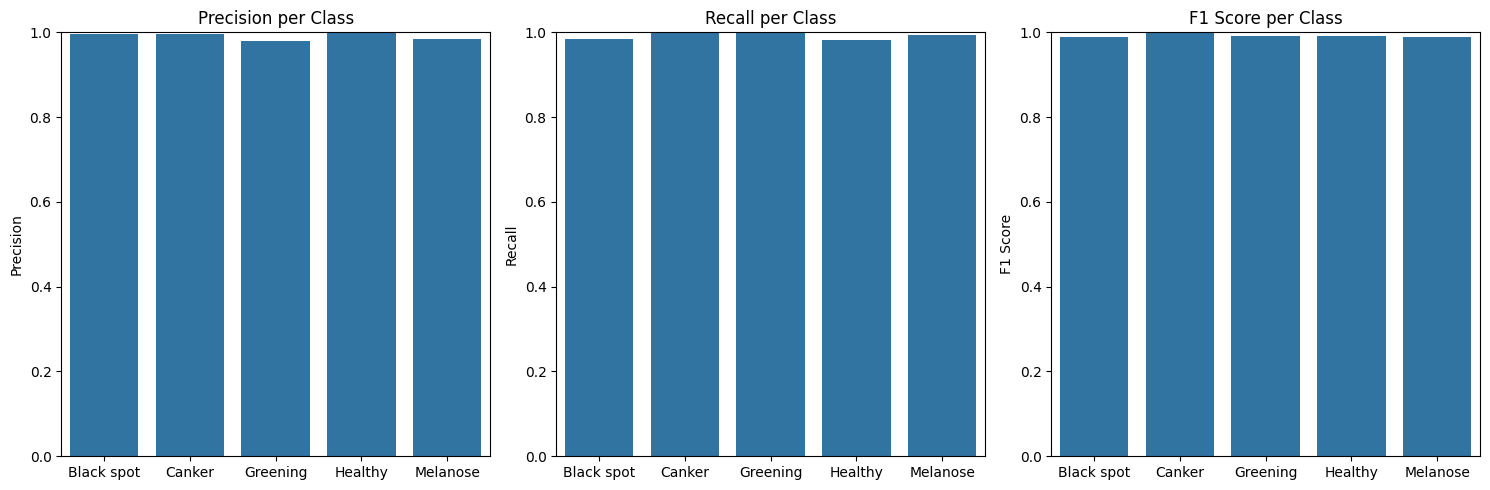

In [ ]:
## Calculate F1-score, Precision, Recall for Each Class
from sklearn.metrics import classification_report

# Assuming y_true and y_pred are already defined from previous cells
class_labels = ['Black spot', 'Canker', 'Greening', 'Healthy', 'Melanose']

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)

# Extract Precision, Recall, and F1 Score for each class
precision_per_class = {label: report[label]['precision'] for label in class_labels}
recall_per_class = {label: report[label]['recall'] for label in class_labels}
f1_per_class = {label: report[label]['f1-score'] for label in class_labels}

# Print the results
print("Precision per class:")
for label, score in precision_per_class.items():
    print(f"{label}: {score}")

print("\nRecall per class:")
for label, score in recall_per_class.items():
    print(f"{label}: {score}")

print("\nF1 Score per class:")
for label, score in f1_per_class.items():
    print(f"{label}: {score}")

# Plotting Precision, Recall, and F1 Score for each class
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.barplot(x=list(precision_per_class.keys()), y=list(precision_per_class.values()))
plt.ylim(0, 1)
plt.title('Precision per Class')
plt.ylabel('Precision')

plt.subplot(1, 3, 2)
sns.barplot(x=list(recall_per_class.keys()), y=list(recall_per_class.values()))
plt.ylim(0, 1)
plt.title('Recall per Class')
plt.ylabel('Recall')

plt.subplot(1, 3, 3)
sns.barplot(x=list(f1_per_class.keys()), y=list(f1_per_class.values()))
plt.ylim(0, 1)
plt.title('F1 Score per Class')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()


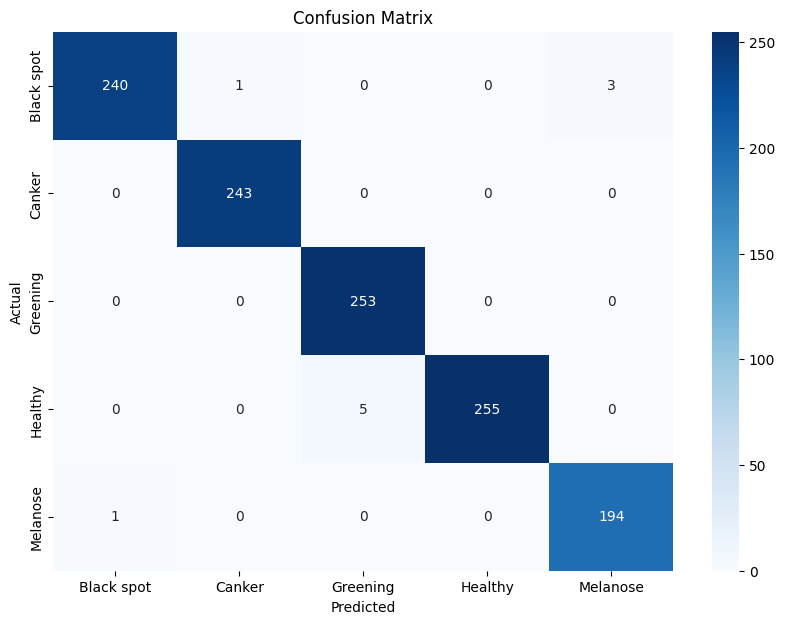

In [ ]:
## Confusion Matrix with Class Labels
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming y_true and y_pred are already defined from previous cells
class_labels = ['Black spot', 'Canker', 'Greening', 'Healthy', 'Melanose']

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
## Save the Model
# Save the model
model_save_path = 'citrus_mbv3_model.h5'
citrus.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to citrus_mbv3_model.h5


In [ ]:
import os
import shutil

def get_model_size(model):
    model.save('temp_model')
    size = sum(os.path.getsize(os.path.join('temp_model', f)) for f in os.listdir('temp_model') if os.path.isfile(os.path.join('temp_model', f)))
    size_mb = size / (1024 * 1024)  # Đổi từ byte sang MB
    shutil.rmtree('temp_model')  # Xóa thư mục tạm thời sau khi tính toán
    return size_mb

model_size_mb = get_model_size(citrus)
print(f'Model size: {model_size_mb:.2f} MB')

Model size: 3.06 MB


In [ ]:
import time
import numpy as np

def get_inference_time(model, input_shape=(224, 224, 3)):
    input_data = np.random.random([1] + list(input_shape)).astype(np.float32)
    start_time = time.time()
    _ = model.predict(input_data)
    end_time = time.time()
    inference_time_ms = (end_time - start_time) * 1000  # Đổi từ giây sang mili giây
    return inference_time_ms

inference_time_ms = get_inference_time(citrus)
print(f'Speed of single image recognition: {inference_time_ms:.2f} ms')


1/1 [==============================] - 0s 46ms/step
Speed of single image recognition: 101.76 ms
